In [1]:
%pip install -q huggingface_hub open_clip_torch pystac_client

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# !git clone https://github.com/ChenDelong1999/RemoteCLIP/ --depth 1

In [1]:
%env AWS_REQUEST_PAYER=requester

env: AWS_REQUEST_PAYER=requester


In [2]:
from os.path import join

from huggingface_hub import hf_hub_download
import torch, open_clip
from PIL import Image
from IPython.display import display

In [ ]:
# for model_name in ['RN50', 'ViT-B-32', 'ViT-L-14']: #all models
#     checkpoint_path = hf_hub_download("chendelong/RemoteCLIP", f"RemoteCLIP-{model_name}.pt", cache_dir='checkpoints')
#     print(f'{model_name} is downloaded to {checkpoint_path}.')

In [3]:
# model_name = 'RN50'
# model_name = 'ViT-B-32'
model_name = 'ViT-L-14'
model, _, preprocess = open_clip.create_model_and_transforms(model_name)
tokenizer = open_clip.get_tokenizer(model_name)

print('#params: ', f'{sum(p.numel() for p in model.parameters()):,}')

#params:  427,616,513


In [4]:
checkpoints_dir = 'checkpoints/models--chendelong--RemoteCLIP/snapshots/bf1d8a3ccf2ddbf7c875705e46373bfe542bce38'

ckpt = torch.load(join(checkpoints_dir, f'RemoteCLIP-{model_name}.pt'))
message = model.load_state_dict(ckpt)
# model = model.cuda().eval()
model = model.cuda().eval()

---

In [5]:
from rastervision.core.box import Box
from rastervision.core.data import RasterioSource, Scene, StatsTransformer
from rastervision.pytorch_learner.dataset import (
    SemanticSegmentationSlidingWindowGeoDataset)

from tqdm.auto import tqdm
import albumentations as A
import numpy as np
import torch
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import seaborn as sns
sns.reset_defaults()

In [6]:
def show_windows(img, windows, scores, figsize, title=''):
    from matplotlib import pyplot as plt
    import matplotlib.patches as patches

    fig, ax = plt.subplots(1, 1, squeeze=True, figsize=figsize)
    ax.imshow(img)
    ax.axis('off')
    # draw windows on top of the image
    for w, score in zip(windows, scores):
        p = patches.Polygon(w.to_points(), color='r', alpha=score * 0.5, linewidth=1)
        ax.add_patch(p)
    ax.autoscale()
    ax.set_title(title)
    plt.show()

def show_top_chips(chip_scores, raster_source, windows, top_inds=None, nrows=5, ncols=5, figsize=(12, 12), w_pad=-2.5, h_pad=-2.5):
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
    fig.tight_layout(w_pad=w_pad, h_pad=h_pad)
    if top_inds is None:
        top_inds = torch.topk(chip_scores, axs.size).indices
    for ax, ind in zip(axs.flat, top_inds):
        chip = raster_source.get_chip(windows[ind])
        ax.imshow(chip)
    for ax in axs.flat:
        ax.axis('off')
    plt.show()

---

In [7]:
import pystac_client
from shapely.geometry import mapping

bbox = Box(39.96, -75.357, 39.855, -75.13)
catalog = pystac_client.Client.open('https://earth-search.aws.element84.com/v1')
bbox_geometry = mapping(bbox.to_shapely().oriented_envelope)
items = catalog.search(
    intersects=bbox_geometry,
    collections=['naip'],
    datetime='2019-01-01/2019-12-31',
    # query={'eo:cloud_cover': {
    #     'lt': 5
    # }},
).get_all_items()
items

In [ ]:
item = items[0]
item

---

In [90]:
# !aws s3 cp s3://naip-analytic/pa/2019/60cm/rgbir_cog/39075/m_3907507_nw_18_060_20191019.tif m_3907507_nw_18_060_20191019.tif --request-payer requester
# !aws s3 cp s3://naip-analytic/pa/2019/60cm/rgbir_cog/39075/m_3907506_nw_18_060_20191019.tif m_3907506_nw_18_060_20191019.tif --request-payer requester
# !aws s3 cp s3://naip-analytic/pa/2019/60cm/rgbir_cog/39075/m_3907506_ne_18_060_20191019.tif m_3907506_ne_18_060_20191019.tif --request-payer requester
# !aws s3 cp s3://naip-analytic/pa/2019/60cm/rgbir_cog/39075/m_3907507_ne_18_060_20191015.tif m_3907507_ne_18_060_20191015.tif --request-payer requester

download: s3://naip-analytic/pa/2019/60cm/rgbir_cog/39075/m_3907507_nw_18_060_20191019.tif to ./m_3907507_nw_18_060_20191019.tif
download: s3://naip-analytic/pa/2019/60cm/rgbir_cog/39075/m_3907506_nw_18_060_20191019.tif to ./m_3907506_nw_18_060_20191019.tif
download: s3://naip-analytic/pa/2019/60cm/rgbir_cog/39075/m_3907506_ne_18_060_20191019.tif to ./m_3907506_ne_18_060_20191019.tif


In [8]:
rs = RasterioSource(uris=[
    'm_3907507_nw_18_060_20191019.tif', 
    'm_3907506_nw_18_060_20191019.tif', 
    'm_3907507_ne_18_060_20191015.tif', 
    'm_3907506_ne_18_060_20191019.tif', 
    ], 
    channel_order=[0, 1, 2])
# rs = RasterioSource('s3://naip-analytic/pa/2019/60cm/rgbir_cog/39075/m_3907507_ne_18_060_20191015.tif', allow_streaming=True)
# rs = RasterioSource(item.assets['image'].href, allow_streaming=True)
rs.shape, rs.dtype

2024-03-08 21:37:34:rastervision.core.data.utils.rasterio: INFO - Building VRT...
INFO:rastervision.core.data.utils.rasterio:Building VRT...


0...10...20...30...40...50...60...70...80...90...100 - done.


((12569, 36615, 3), dtype('uint8'))

In [ ]:
# img = rs[:, :]
# img.shape

In [11]:
scene = Scene('', raster_source=rs)
ds = SemanticSegmentationSlidingWindowGeoDataset(
    scene,
    size=400,
    stride=400,
    padding=0,
    transform=A.Resize(224, 224),
)
dl = DataLoader(ds, batch_size=32, num_workers=4)
len(ds)

2821

In [14]:
embs = []
with torch.inference_mode(), tqdm(dl, desc='Creating chip embeddings') as bar:
    for x, _ in bar:
        x = x.cuda()
        # _emb_1 = model.encode_image(x)
        # _emb_2 = model.encode_image(x.flip(2))
        # _emb_3 = model.encode_image(x.flip(3))
        # _emb_4 = model.encode_image(x.flip(2).flip(3))
        # emb = sum([_emb_1, _emb_2, _emb_3, _emb_4]) / 4
        emb = model.encode_image(x)
        embs.append(emb.cpu())
embs = torch.cat(embs, dim=0)
embs /= embs.norm(dim=-1, keepdim=True)
embs.shape

Creating chip embeddings:   0%|          | 0/89 [00:00<?, ?it/s]

torch.Size([2821, 768])

In [15]:
torch.save(embs, 'RemoteCLIP_naip_embeddings_400_400.pt')

In [ ]:
embs = torch.load('RemoteCLIP_naip_embeddings_400_400.pt')
embs.shape

In [17]:
model = model.cpu()
torch.cuda.empty_cache()

In [100]:
T = 0.01
text_queries = [
    # 'houses with swimming pools',
    # 'trees along a river bank',
    # 'power transmission lines',
    # 'running track',
    # 'baseball pitch',
    # 'soccer pitch',
    # 'power plant',
    # 'warehouses',
    # 'multi-lane road',
    # '1 tennis court',
    '10 tennis courts',
    # 'satellite view of a skyscraper casting a shadow',
    # 'empty road',
]
assert len(text_queries) == 1
text = tokenizer(text_queries)
with torch.inference_mode():
    text_features = model.encode_text(text)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_features = text_features.cpu()
    chip_scores = torch.cosine_similarity(text_features, embs)
    # chip_scores = (chip_scores / T).softmax(dim=0)
    # chip_scores = chip_scores / chip_scores.max()
    
# show_windows(img, ds.windows, chip_scores, figsize=(10, 12))

# thresh = chip_scores.mean() + 3*chip_scores.std()
# top_inds = np.where(chip_scores > thresh)[0]
# top_vals = chip_scores[top_inds]
# top_inds = top_inds[np.argsort(top_vals).flip(0)]
# top_inds = None
# show_top_chips(chip_scores, rs, ds.windows, top_inds, nrows=5, figsize=(12, 12))

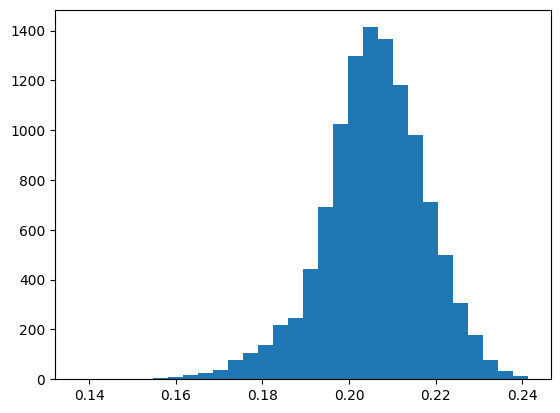

In [58]:
plt.hist(chip_scores, bins=30)
plt.show()

In [67]:
torch.allclose(torch.cosine_similarity(text_features, embs), torch.matmul(text_features, embs.T))

True

---

In [22]:
from rastervision.pipeline.file_system.utils import json_to_file
from rastervision.core.data import ClassConfig, boxes_to_geojson

In [25]:
geojson = boxes_to_geojson(
    ds.windows, [0] * len(ds), rs.crs_transformer, ClassConfig(names=text_queries), scores=chip_scores.tolist())

json_to_file(geojson, f'RemoteCLIP_naip_{text_queries[0]}.json')

---

In [20]:
chip_scores_1 = chip_scores

In [22]:
chip_scores_2 = chip_scores

In [24]:
chip_scores_3 = chip_scores

In [101]:
chip_scores_10 = chip_scores

In [111]:
n_imgs = 1
n_matches = 3

img_inds_1 = torch.topk(chip_scores_1, n_matches).indices[:n_imgs]
imgs_1 = [rs.get_chip(ds.windows[i]) for i in tqdm(img_inds_1)]

img_inds_2 = torch.topk(chip_scores_2, n_matches).indices[:n_imgs]
imgs_2 = [rs.get_chip(ds.windows[i]) for i in tqdm(img_inds_2)]

img_inds_3 = torch.topk(chip_scores_3, n_matches).indices[:n_imgs]
imgs_3 = [rs.get_chip(ds.windows[i]) for i in tqdm(img_inds_3)]

img_inds_10 = torch.topk(chip_scores_10, n_matches).indices[:n_imgs]
imgs_10 = [rs.get_chip(ds.windows[i]) for i in tqdm(img_inds_10)]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [112]:
bg_alpha = 0.6
fg_alpha = 1.1

alpha_mask_1 = np.full((400, 400, 1), bg_alpha)
alpha_mask_1[0:100, 200:300] = fg_alpha
imgs_1[0] = (imgs_1[0] / 255) * alpha_mask_1

alpha_mask_2 = np.full((400, 400, 1), bg_alpha)
alpha_mask_2[300:, 300:] = fg_alpha
imgs_2[0] = (imgs_2[0] / 255) * alpha_mask_2

alpha_mask_3 = np.full((400, 400, 1), bg_alpha)
alpha_mask_3[300:, 0:100] = fg_alpha
imgs_3[0] = (imgs_3[0] / 255) * alpha_mask_3

alpha_mask_10 = np.full((400, 400, 1), bg_alpha)
alpha_mask_10[250:, 150:300] = fg_alpha
imgs_10[0] = (imgs_10[0] / 255) * alpha_mask_10

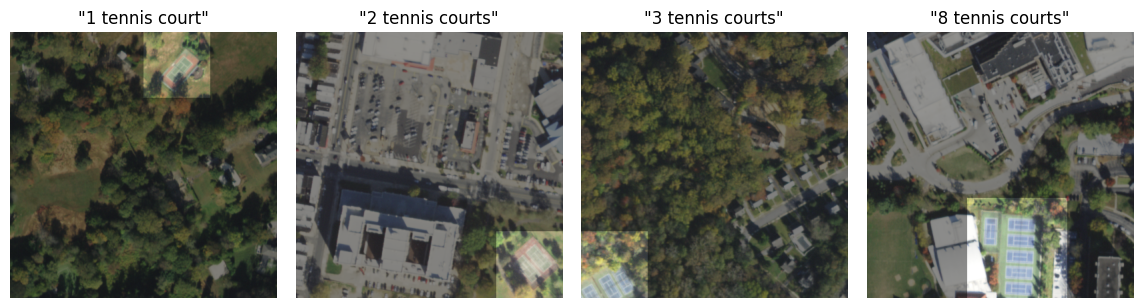

In [114]:
fig, axs = plt.subplots(1, 4, figsize=(12, 4), squeeze=False)
fig.tight_layout(w_pad=-2)
# fig.subplots_adjust(top=0.9)
# fig.suptitle('RemoteCLIP resutls for:', fontsize=14)
titles = [
    '1 tennis court', 
    '2 tennis courts',
    '3 tennis courts',
    '8 tennis courts',
]
for axs_col, imgs, title in zip(axs.T, [imgs_1, imgs_2, imgs_3, imgs_10], titles):
    axs_col[0].set_title(f'"{title}"')
    for ax, img in zip(axs_col, imgs):
        ax.imshow(img)
        ax.axis('off')
plt.show()

In [115]:
fig.savefig('qe_naip_count.png', bbox_inches='tight', pad_inches=0.2)